**This Python 3 notebook extracts images of a Gallica document (using the IIIF protocol), and then applies an IBM Watson classification model to the images**
1. Extract the document bibliographical metadata from the Gallica OAI-PMH repository
2. Extract the document technical image metadata from its IIIF manifest, and then the images
3. Classify the images with a Watson Cloud Vision model (the model must be available)

<i>Prerequisites</i>:
- a pretrained  Watson Sudio classification model identified with its ID
- a Watson API key

In [1]:
# insert here the Gallica document ID you want to process
doc_ID = '12148/btv1b10336854c'
# CSV export
output = "OUT_csv"
# get doc_max first images from the document
doc_max = 2
# IIIF export factor (%)
doc_export_factor = 20

In [2]:
import sys
print("Python version")
print (sys.version)

Python version
3.8.6 (default, Nov 16 2020, 11:50:36) 
[Clang 10.0.1 (clang-1001.0.46.4)]


### 1. PyGallica (https://github.com/ian-nai/PyGallica) is used to access the Gallica OAI and get some bibliographic metadata. The call returns metadata as a dictionary

In [3]:
# we import the Document class from the PyGallica package (https://github.com/ian-nai/PyGallica)
from document_api import Document

In [4]:
# we get the document metadata with the Gallica OAI API wrapped within the PyGallica package
#json_dict4doc = Document.OAI(doc_ID)

In [5]:
# do whatever you want with the document bibliographic metadata
# get the title
#print json_dict4doc['results']['title']
# get the Dublin Core medatada
#print json_dict4doc['results']['notice']['record']['metadata']['oai_dc:dc']

### 2. We ask for the document IIIF manifest to then have access to the images files

In [6]:
# we build the IIIF URL
import requests
METADATA_BASEURL = 'https://gallica.bnf.fr/iiif/ark:/'
req_url = "".join([METADATA_BASEURL, doc_ID, '/manifest.json'])
print ("... getting the IIIF manifest",req_url)

... getting the IIIF manifest https://gallica.bnf.fr/iiif/ark:/12148/btv1b10336854c/manifest.json


In [7]:
# we ask for the manifest. The call returns a dictionary
r = requests.get(req_url)
r.raise_for_status()
json_4img = r.json()
print (json_4img.keys())

dict_keys(['@id', 'label', 'attribution', 'license', 'logo', 'related', 'seeAlso', 'description', 'metadata', 'sequences', 'thumbnail', '@type', '@context'])


In [8]:
# get the sequence of images metadata. It's a list
sequences = json_4img.get('sequences')
# get the canvases, first element of the list. Its a dict
canvases = sequences[0]
print (canvases.keys())
# parse each canvas data for each image
# each canvas has these keys: [u'height', u'width', u'@type', u'images', u'label', u'@id', u'thumbnail']
n_images = 0
# the array of URLs we're going to build
urlsIIIF = [] 
print ("... getting image metadata from the IIIF manifest")
for c in canvases.get('canvases'): 
    n_images += 1
    print ("    label:",c.get('label')," width:",c.get('width'), " height:",c.get('height'))
    # we also get a Gallica thumbnail (it's not a IIIF image)
    thumbnail = c.get('thumbnail')
    urlThumbnail = thumbnail.get('@id')
    # we build the IIIF URL. We ask for the full image with a size factor of docExportFactor
    urlIIIF = "".join([doc_ID,'/f',str(n_images)]), 'full', "".join(['pct:',str(doc_export_factor)]), '0', 'native', 'jpg'
    urlsIIIF.append(urlIIIF)
    if n_images >= doc_max:
        break
        
print ("--------------")
print (f"... we get {doc_max} images on {len(canvases.get('canvases'))}\n")

dict_keys(['canvases', 'label', '@type', '@id'])
... getting image metadata from the IIIF manifest
    label: NP  width: 6255  height: 8490
    label: NP  width: 3114  height: 5371
--------------
... we get 2 images on 18



In [9]:
# Now we'd like to get the image files with the IIIF Image API (PyGallica package again)
from iiif_api import IIIF

In [10]:
# Now loading the images
# the files are stored in the . folder
[IIIF.iiif(u[0],u[1],u[2],u[3],u[4],u[5]) for u in urlsIIIF]

"""
# get the image files #x to #y (we only process y-x images)
for i in range(8, 9):
    print ("--- getting image...")
    # we build the IIIF URL. We ask for the full image with a size factor of docExportFactor
    IIIF.iiif("".join([docID,'/f',str(i)]), 'full', "".join(['pct:',str(doc_export_factor)]), '0', 'native', 'jpg')
"""
print ("... done")

https://gallica.bnf.fr/iiif/ark:/12148/btv1b10336854c/f1/full/pct:20/0/native.jpg
https://gallica.bnf.fr/iiif/ark:/12148/btv1b10336854c/f2/full/pct:20/0/native.jpg
... done


### 3. Now we have to call the Watson classification model on the local image files


... CSV files will be saved to /Users/bnf/Documents/BnF/Dev/Atelier_ia_CNN/ateliers/classify-with-Watson/OUT_csv
--- infering image  12148/btv1b10336854c/f1.jpg  ...


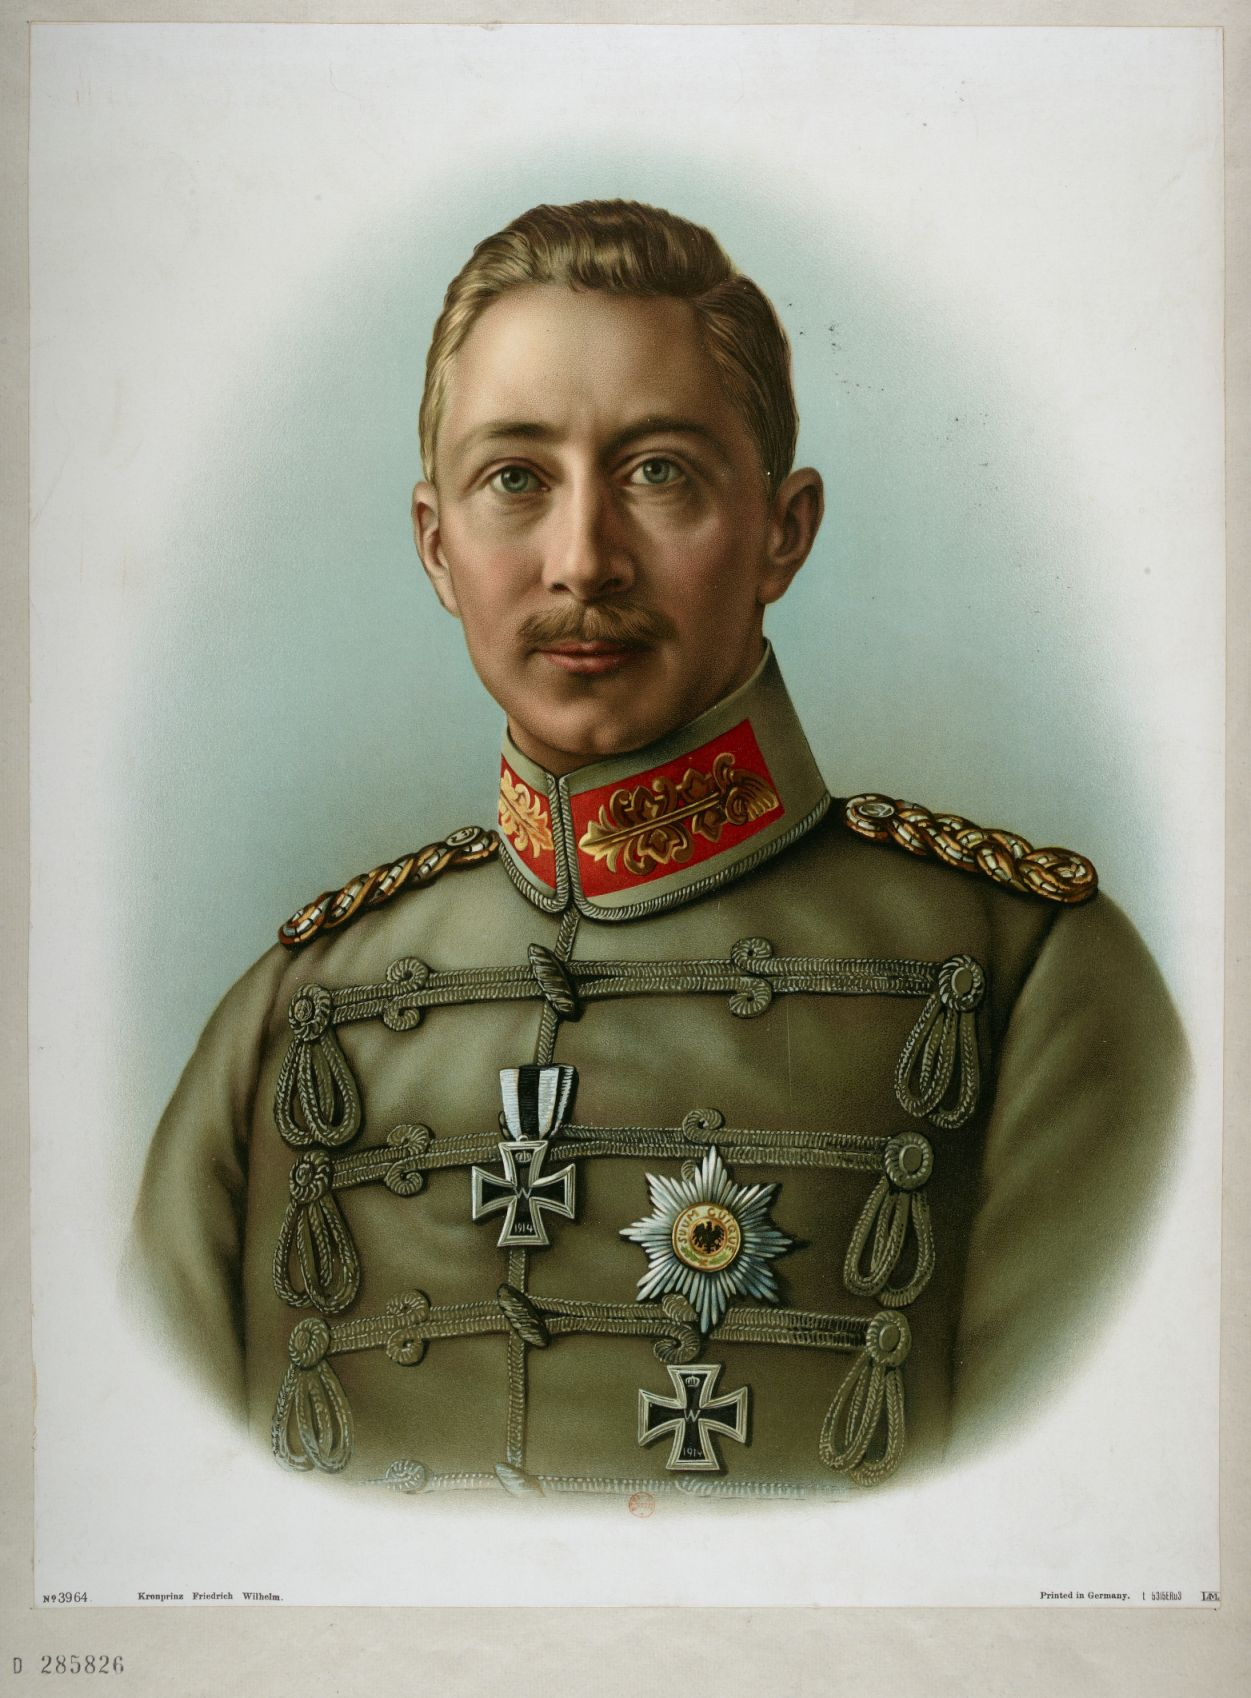

    -> classification: Filtre_30
    -> confidence score: 0.685
--- infering image  12148/btv1b10336854c/f2.jpg  ...


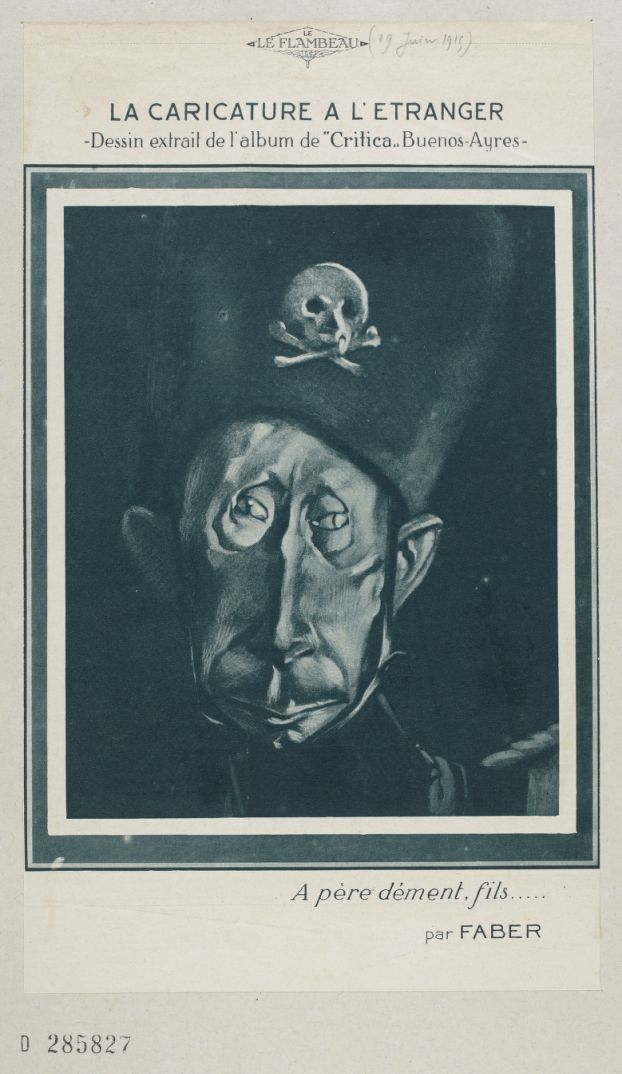

    -> classification: Photo_30
    -> confidence score: 0.893

... writing classification data in OUT_csv


In [11]:
import json
import PIL.Image
from IPython.display import Image, display
import os, fnmatch

#######################
outputDir = os.path.realpath(output)
if not os.path.isdir(outputDir):
    print(f"\n  Output .csv directory {outputDir} does not exist!")
    os.mkdir( outputDir);
else:
    print (f"\n... CSV files will be saved to {outputDir}")
    
# Watson parameters:
WATSON_BASEURL = 'https://gateway.watsonplatform.net/visual-recognition/api/v3/classify?version=2018-03-19'
WATSON_VERSION = (('version', '2018-03-19'),)
# insert your Watson key here
WATSON_KEY = '2DZdFVOxmhJnQIq3MOQsUOg-7RqARAWa35q-Gh31NnSK' 
# insert your Watson visual recognition model ID here
WATSON_MODEL = 'DefaultCustomModel_1457318034'

def process_image(file_name):
    # we use the requests package
    files = {
        'images_file': (file_name, open(file_name, 'rb')),
        'classifier_ids': (None, WATSON_MODEL),
    }
    # calling the Watson API 
    return requests.post('https://gateway.watsonplatform.net/visual-recognition/api/v3/classify',params=WATSON_VERSION, files=files, auth=('apikey', '2DZdFVOxmhJnQIq3MOQsUOg-7RqARAWa35q-Gh31NnSK'))

def process_json(watson_json):
    images = watson_json.get('images')
    watson_class = images[0].get('classifiers')[0].get('classes')[0].get('class')
    watson_score = images[0].get('classifiers')[0].get('classes')[0].get('score')
    print ("    -> classification:",watson_class)
    print ("    -> confidence score:",watson_score)
    return(watson_class,watson_score)
    
# writing the results in out_path
out_path = os.path.join(output, "classifications.csv" )
out_file = open(out_path,"w")

# first we read the images
# the images have been stored in a folder based on the document ID
# like 12148/btv1b103365619
entries = fnmatch.filter(os.listdir(doc_ID), '*.jpg')
for file in entries:
    file_name = "".join([doc_ID,"/",file])
    print ("--- infering image ",file_name," ...")
    # we display the image
    #img = Image.open(file_name)
    #img.show() 
    display(Image(filename=file_name))
    # calling the Watson API 
    watson_json = process_image(file_name).json()
    # Watson returns a JSON with classification and confidence score informations
    #print(json.dumps(json_watson, sort_keys=True, indent=4))  
    result = process_json(watson_json)
    predicted_class = result[0]
    predicted_class = predicted_class[:-3]
    # write in file
    print ("%s\t%s" % (file_name, predicted_class.lower()), file=out_file)
    
out_file.close()
print ("\n... writing classification data in",output)
exit(0)


### 4. We evaluate the performances relatively to a ground truth


--- GT class  carte  ...
    infering image: GT/carte/carte_21.jpg  ...
    -> classification: Carte_30
    -> confidence score: 0.905
    infering image: GT/carte/carte_20.jpg  ...
    -> classification: Carte_30
    -> confidence score: 0.899

--- GT class  dessin  ...
    infering image: GT/dessin/dessin_22.jpg  ...
    -> classification: Filtre_30
    -> confidence score: 0.901
    infering image: GT/dessin/dessin_21.jpg  ...
    -> classification: Dessin_30
    -> confidence score: 0.873
    infering image: GT/dessin/dessin.jpg  ...
    -> classification: Filtre_30
    -> confidence score: 0.847
    infering image: GT/dessin/dessin_2.jpg  ...
    -> classification: Dessin_30
    -> confidence score: 0.869

--- GT class  photo  ...
    infering image: GT/photo/photo_20.jpg  ...
    -> classification: Photo_30
    -> confidence score: 0.905
    infering image: GT/photo/photo_21.jpg  ...
    -> classification: Filtre_30
    -> confidence score: 0.726
    infering image: GT/photo/pho

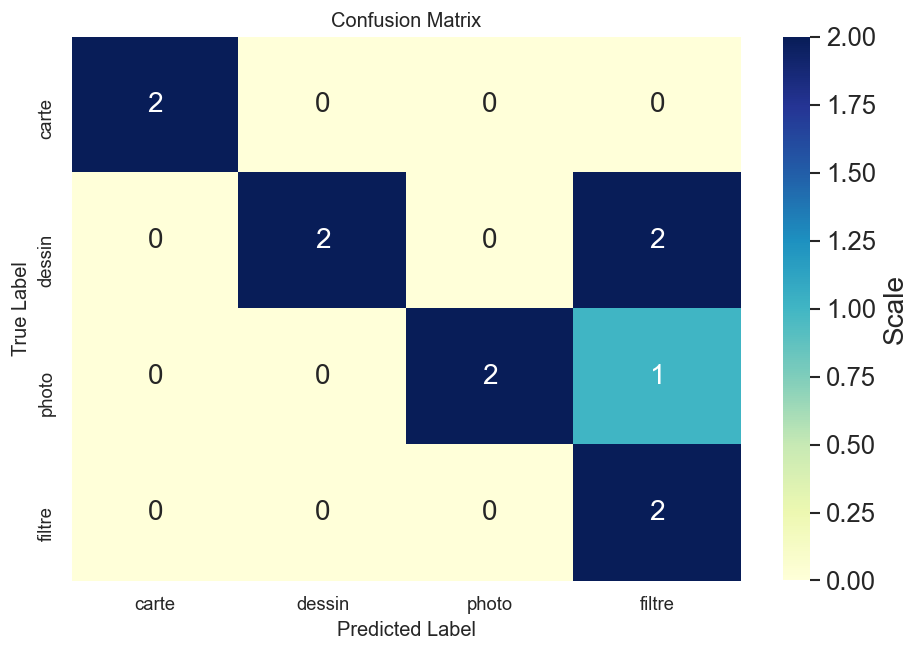

In [12]:
GT_folder = "GT"
labels = []
predictions = []
predictions = []
trues = []

# infering the GT data
folders = fnmatch.filter(os.listdir(GT_folder), '*')
for f in folders:
    folder_name = "".join([GT_folder,"/",f])
    if os.path.isdir(folder_name):
        print ("\n--- GT class ",f," ...")
        labels.append(f)
        images = fnmatch.filter(os.listdir(folder_name), '*.jpg')
        for i in images:
            trues.append(f)
            file_name = "".join([GT_folder,"/",f,"/",i])
            print ("    infering image:",file_name," ...")
            watson_json = process_image(file_name).json()
            result = process_json(watson_json)
            predicted_class = result[0]
            predicted_class = predicted_class[:-3] # remove the "_30" (class names in the Watson model)
            predictions.append(predicted_class.lower())
print ("classes:",labels)
print ("GT:", trues)
print ("predictions:",predictions)

# computing the preformances: confusion matrix, recall, precision
import seaborn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=120)
    plt.close()
 
 
# create confusion matrix
matrix = confusion_matrix(trues, predictions, labels=labels)
print (matrix)

# compute the recall score
# https://simonhessner.de/why-are-precision-recall-and-f1-score-equal-when-using-micro-averaging-in-a-multi-class-problem/
# 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
# 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
print ("\nrecall score:", recall_score(trues, predictions, labels=labels, average='micro'))
print ("precision score:", precision_score(trues, predictions, labels=labels, average='micro'))
print ("F1 mesure:", f1_score(trues, predictions, labels=labels, average='micro'))
       
# draw the matrix
plot_confusion_matrix(matrix, labels, "confusion_matrix.png")
display(Image(filename="confusion_matrix.png"))
exit(0)

### 5. We could do the same on a IIIF image URL

--- infering image  https://iiif.wellcomecollection.org/image/L0009407.jpg/1,1,1568,1213/1000,/0/default.jpg  ...


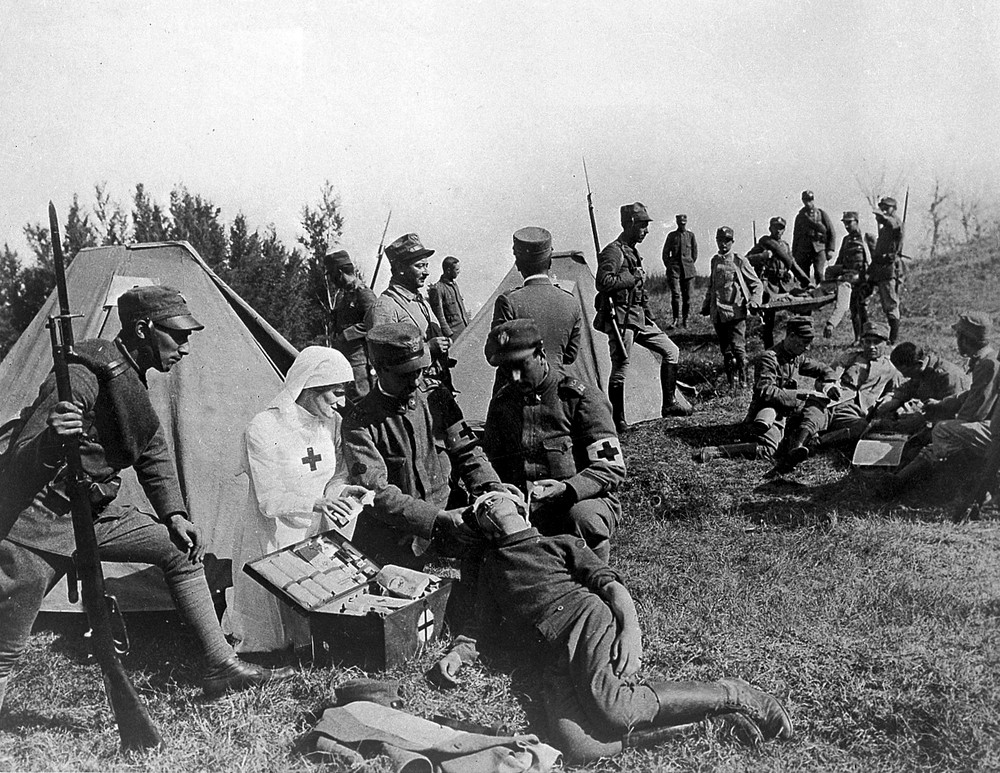

{
    "custom_classes": 4,
    "images": [
        {
            "classifiers": [
                {
                    "classes": [
                        {
                            "class": "Photo_30",
                            "score": 0.902
                        }
                    ],
                    "classifier_id": "DefaultCustomModel_1457318034",
                    "name": "Default Custom Model"
                }
            ],
            "resolved_url": "https://iiif.wellcomecollection.org/image/L0009407.jpg/1,1,1568,1213/1000,/0/default.jpg",
            "source_url": "https://iiif.wellcomecollection.org/image/L0009407.jpg/1,1,1568,1213/1000,/0/default.jpg"
        }
    ],
    "images_processed": 1
}


In [13]:
import requests
# Wellcome collection
iiifURL = "https://iiif.wellcomecollection.org/image/L0009407.jpg/1,1,1568,1213/1000,/0/default.jpg"
# Gallica
#iiifURL = "https://gallica.bnf.fr/iiif/ark:/12148/bpt6k4628326j/f1/4317.695641814265,2899.28514719721,1006.9642711679644,774.944853848157/217,167/0/native.jpg"
CURL_URL = (('url', iiifURL),)
WATSON_CLASSIFIER = (('classifier_ids', WATSON_MODEL),)
curlParams = {
        'url': (None, iiifURL),
        'classifier_ids': (None, WATSON_MODEL),
        'version': (None, '2018-03-19')
    }
print ("--- infering image ",iiifURL," ...")
img = PIL.Image.open(requests.get(iiifURL, stream=True).raw)
#img.show() 
display(img)
# call to the Watson API 
response = requests.post('https://gateway.watsonplatform.net/visual-recognition/api/v3/classify',params=curlParams, auth=('apikey', '2DZdFVOxmhJnQIq3MOQsUOg-7RqARAWa35q-Gh31NnSK'))
json_watson = response.json()
print(json.dumps(json_watson, sort_keys=True, indent=4)) 
